In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
from torch import nn
from torch.optim import AdamW
import numpy as np
from random import randint, choices

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Model.pt


In [2]:
#This code was translated from the R-code: https://github.com/AGPatriota/ALGA-R
#with the help of ChatGPT. Some corrections were needed to work properly
#If you find any problems, please contect me: patriota [at] ime [dot] usp [dot] br

config = {
    'digits': 1000,
    'train': True,
    'test' : True,
    'iter': 2000,
    'block_size': 5,
    'block_train': 5,
    'block_size_out': 4,
    'max': 5,
    'n_embd': 64,
    'N_Layers': 2,
    'n_head': 2,
    'lr': 0.0005,
    'batch_size': 16 * 32,
    'epochs': 150,
    'p0': 0.2,
    'p1': 0.2
}


In [3]:
def intercalar(input_str):
    # Split the input into two numbers
    parts = input_str.split('+')
    
    num1 = list(parts[0])
    num2 = list(parts[1])
    
    # Add zeros to the left
    max_len = max(len(num1), len(num2))
    num1 = ['0'] * (max_len - len(num1)) + num1
    num2 = ['0'] * (max_len - len(num2)) + num2
    
    # Intercalate the digits
    intercalated = ''.join(n1 + n2 for n1, n2 in zip(num1, num2))
    
    return intercalated

# Example
input_str = "123+4567"
result = intercalar(input_str)
print(result) 


04152637


In [4]:
from torch.nn.functional import softmax
from random import choices, sample

# Vocabulary
Voc = ["P", "S", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "\n", "C"]
# Set device
device0 = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device0)
def Encoder(file, vocabulary=Voc):
    return [vocabulary.index(char) if char in vocabulary else 0 for char in file]

def Decoder(file, vocabulary=Voc):
    return ''.join([vocabulary[idx] if idx < len(vocabulary) else '' for idx in file])


def Generate(idx, model, block_size_out, max_new_tokens=3, temperature=0.7, top_k=None, device00=device0, print_flag=True):
    if print_flag:
        print("\n\n===================== Generating Tokens =====================\n\n")
        decoded_prompt = Decoder(idx)  # Decoding the initial indices
        decoded_prompt = [char for char in decoded_prompt if char != "P"]
        print(f"Prompt:\n{''.join(decoded_prompt)}\n")
    
    idx = torch.tensor(idx, dtype=torch.int64, device=device00).unsqueeze(0)
    # Start token setup with correct index for Python
    y = torch.tensor([12], dtype=torch.int64, device=device00).unsqueeze(1)
    
    with torch.no_grad():
        model.eval()
        for i in range(max_new_tokens):
            if y.size(1) <= block_size_out:
                y_cond = y
            else:
                y_cond = y[:, -block_size_out:]  # Taking the last 'block_size_out' tokens
            logits = model.eval()(idx, y_cond)

            q = min(i, logits.size(1)-1)
            logits = logits[:, q] / temperature  # Get the last set of logits and scale by temperature
            if top_k is not None:
                values, indices = torch.topk(logits, top_k)
                probs = softmax(values, dim=-1)
                next_token_idx = torch.multinomial(probs, num_samples=1)
                y_next = indices.gather(-1, next_token_idx).unsqueeze(1)
            else:
                y_next = logits.argmax(-1).unsqueeze(-1)  # Taking the most likely next token
            # Breaking if a specific token (assumed to be stop token) is generated
            if y_next.item() == 1:  # This needs to be adjusted based on the actual stopping condition
                break

            y = torch.cat([y, y_next], dim=1)
            if print_flag:
                d = y_next.to('cpu').squeeze().tolist()
        if print_flag:
            print("\n")
        y = y.to('cpu').squeeze().tolist()  # Convert tensor to list for final output
        return y
        return [Decoder([tok]) for tok in y]  # Wrap tok in a list before decoding

        
def Add(num1):
    num1 = [int(n) for n in num1]
    total = sum(num1)
    return total, 1 if total >= 10 else 0


def Add1(num1, num2=None):
    if num2 is None:
        y = Add(num1)[0]
        return {'x': num1, 'y': f"\n{y}S"}
    if len(num2) < 2:
        num2 = f"0{num2}"
    total, carry = Add(num1)
    num21 = int(num2[0])
    num22 = int(num2[1])
    return {'x': f"{total}C{num2}", 'y': f"\n{num21 + num22 + carry}S"}

def Gen(batch_size=16, device00=device0):
    x = []
    y = []
    for _ in range(batch_size):
        num1 = ''.join([str(randint(0, 9)) for _ in range(randint(1, 2))])
        num2 = None
        if np.random.rand() < 0.5:
            num2 = ''.join([str(randint(0, 9)) for _ in range(randint(1, 2))])
        z = Add1(num1, num2)
        if len(z['y']) < config['block_size_out']:
            num_chars_needed = config['block_size_out'] - len(z['y'])
            z['y'] += "P" * num_chars_needed
        if len(z['x']) < config['block_size']:
            num_chars_needed = config['block_size'] - len(z['x'])
            z['x'] += "P" * num_chars_needed
        x.append(Encoder(z['x']))
        y.append(Encoder(z['y']))
    x_tensor = torch.tensor(x, dtype=torch.int64, device=device00)
    y_tensor = torch.tensor(y, dtype=torch.int64, device=device00)
    return {'x': x_tensor, 'y': y_tensor}


cpu


In [5]:
from torch.nn import functional as F

class GPT(nn.Module):
    def __init__(self, block_size, block_size_out, n_embd, N_Layers, nvoc, Head, p0, p1):
        super(GPT, self).__init__()
        self.N = N_Layers
        self.block_size = block_size
        self.block_size_out = block_size_out
        self.wpe_out = nn.Embedding(block_size + block_size_out, n_embd)
        self.wte_out = nn.Embedding(nvoc, n_embd, padding_idx=0)
        self.MH_dec = nn.ModuleList([nn.MultiheadAttention(n_embd, Head, dropout=p1) for _ in range(N_Layers)])
        self.scale1_dec = nn.ModuleList([nn.LayerNorm(n_embd) for _ in range(N_Layers)])
        self.scale2_dec = nn.ModuleList([nn.LayerNorm(n_embd) for _ in range(N_Layers)])
        self.scale3 = nn.LayerNorm(n_embd, elementwise_affine=True)
        self.FFN_dec = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_embd, 4 * n_embd),
                nn.GELU(),
                nn.Linear(4 * n_embd, n_embd),
                nn.Dropout(p0)
            ) for _ in range(N_Layers)
        ])
        self.ln_f = nn.Linear(n_embd, nvoc, bias=False)
        self.drop0_out = nn.Dropout(p=p0)

    def forward(self, x, y):
        y1 = torch.arange(0, x.size(1) + y.size(1), dtype=torch.int64, device=y.device).unsqueeze(0)
        y1 = y1.expand(x.size(0), x.size(1) + y.size(1))       
        wei = torch.zeros((x.size(1) + y.size(1), x.size(1) + y.size(1)), dtype=torch.bool, device=x.device)
        aux =  slice(x.size(1)+1, x.size(1) + y.size(1))
        wei[:x.size(1), aux] = True
        triangular_mask = torch.triu(torch.ones(y.size(1), y.size(1), dtype=torch.bool), diagonal=1)
        block_end = x.size(1) + y.size(1)
        block_start = x.size(1)
        wei[block_start:block_end, block_start:block_end] = triangular_mask
        output = torch.cat([x, y], dim=1)
        output = self.wte_out(output) + self.wpe_out(y1)
        output = self.drop0_out(output)

        
        for j in range(self.N):
            Q = self.scale1_dec[j](output).transpose(0, 1)
            output = output + self.MH_dec[j](Q, Q, Q, attn_mask=wei, need_weights=False)[0].transpose(0, 1)
            output = output + self.FFN_dec[j](self.scale2_dec[j](output))
        
        output = self.ln_f(self.scale3(output))
        return output[:, -(y.size(1)):]
  
model = GPT(block_size=config['block_size'],
            block_size_out=config['block_size_out'],
            n_embd=config['n_embd'],
            N_Layers=config['N_Layers'],
            Head=config['n_head'],
            nvoc=len(Voc),
            p0=config['p0'], 
            p1=config['p1'])

#model.load_state_dict(torch.load(model_save, map_location=torch.device(device0),weights_only=True))
Z = Gen(1)
print(Decoder(Z['x'].squeeze().tolist()), Decoder(Z['y'].squeeze().tolist()))
FIT = model.eval()(Z['x'], torch.tensor([[12]], dtype=torch.int64)) #Z['y'][:,0:2])
Decoder([FIT.argmax(-1).squeeze().tolist()]),Decoder(Z['y'][:,:-1].squeeze().tolist()),Decoder(Z['y'].squeeze().tolist())

8PPPP 
8SP


('P', '\n8S', '\n8SP')

In [6]:
x = Encoder('6C33P')
FIT = model.eval()(torch.tensor([x], dtype=torch.int64), torch.tensor([[12]], dtype=torch.int64))
Decoder([FIT.argmax(-1).squeeze().tolist()]), FIT.argmax(-1).squeeze().tolist(), x

('P', 0, [8, 13, 5, 5, 0])

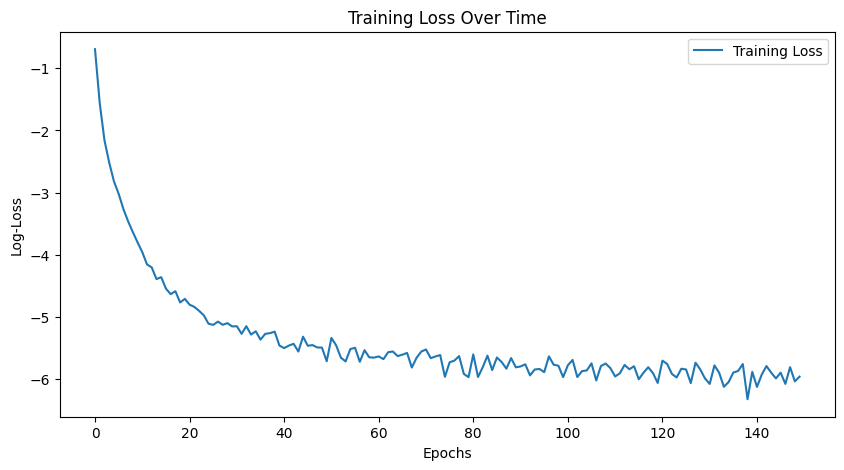

In [7]:
from torch.optim import AdamW
import matplotlib.pyplot as plt
from IPython.display import clear_output

losses_epoc = []

model_save = "Model.pt"



# Model definition
model = GPT(block_size=config['block_size'],
            block_size_out=config['block_size_out'],
            n_embd=config['n_embd'],
            N_Layers=config['N_Layers'],
            Head=config['n_head'],
            nvoc=len(Voc),
            p0=config['p0'], 
            p1=config['p1'])


model.to(device0)


# Training loop
if config['train']:
    !rm -rf /kaggle/working/*
    # Prepare for training
    test = [Gen() for _ in range(10)]
    loss_func = nn.CrossEntropyLoss(reduction="none", ignore_index=0)
    optimizer = AdamW(model.parameters(), lr=config['lr'])

    for i in range(config['epochs']):
        losses = []
        for j in range(config['iter']):
            Z = Gen()
            FIT = model.train()(Z['x'], Z['y'][:, :-1])
            loss = loss_func(FIT.flatten(end_dim=1), Z['y'][:, 1:].flatten())
            loss.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.mean().item())
        losses_epoc.append(np.log(sum(losses)/config['iter']))
        #if j % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(losses_epoc, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Log-Loss')
        plt.title('Training Loss Over Time')
        plt.legend()
        plt.show()

    torch.save(model.state_dict(), model_save)

In [8]:
# After training tests
if config['test']:
    from tqdm import tqdm
    # Load model if exists
    if os.path.exists(model_save):
        model.load_state_dict(torch.load(model_save, map_location=torch.device(device0),weights_only=True))
    model.to(device0)

    ss = []
    n0 = config['digits']


    for i in tqdm(range(1000)):
        x = ''.join([str(randint(0, 9)) for _ in range(randint(1, n0))])
        y = ''.join([str(randint(0, 9)) for _ in range(randint(1, n0))])
        num = intercalar(x + "+" + y)  
        num0 = list(num)
        N = abs(2 - len(num))
        initial_segment = num0[-min(2, len(num0)):] + ['P'] * (config['block_size'] - min(2, len(num0)))
        encoded_initial = Encoder(initial_segment)
        temp = [Generate(encoded_initial, model, config['block_size_out'], config['max'], print_flag=False)]
        s=0
        for l in range(1, N//2+1 , 1):
            l = 2*l+2
            index_start = len(num0) - l
            index_end = index_start + 2
            num1 = temp[s][1:] + [13] + Encoder(num0[index_start:index_end])
            num1 += [0] * (config['block_size'] - len(num1))
            temp.append(Generate(num1, model, config['block_size_out'], config['max'], print_flag=False))
            s += 1
        def get_last_item(sublist):
            return sublist[-1]

        aux = [get_last_item(temp[i]) for i in range(len(temp))]
        a = temp[-1]
        if len(a) in [2]:
            pred = ''.join(Decoder([item]) for item in reversed(aux))
        else:
            pred = ''.join(Decoder(a[1:2] + [item for item in reversed(aux)]))

        pred = pred.replace('P', '').split('S')[0]
        x0, y0 = int(x or '0'), int(y or '0')
        pred = int(pred or '0', 10)
        ss.append((x0 + y0) == pred)
        
        #Show every non-mathing case
        if not ss[-1]:
            print(f"Expected: {x0 + y0}, Predicted: {pred}")

    accuracy = sum(ss) / len(ss) * 100
    print(f"Accuracy: {accuracy}%")

100%|██████████| 1000/1000 [47:25<00:00,  2.85s/it]

Accuracy: 100.0%


In [9]:
#Last test
x0, y0, x0+y0, pred

(635746292872969391640219567099519914742480692165630983681693454006559567018009798032276182018738176225918058193933508595356170451018704699180157589055490858631732477542286429056519956732019726399682401000960500648258834333268840731654329720684202,
 457159302039697466060157088542784388087821170649624769347621223213224252382744273806446341541510287301339635544462693313607909321137041730351987675829800832547602545860100946872099806432079285189580418253193907554183837959708433980917067713304186521011254700597459259436141051658477331032332101092750996808388401723296933824368432799355836174957114113298084274464798979031803739427557384297434554253836269160578708928645097013584835092690036529317131366774278377997654863108107415450659509751514770839863340822077925418505546273973212825320082440002060663662050612084634587387632315665944357360080696009174975859148502383677002313353436882221830369631478370302398807616541223240605359066340902269794692400893076528318624617005385765424970946593306024